In [1]:
import torch
from torch import nn

import torch.functional as F

from PIL import Image
import torchvision.transforms.functional as TF

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import numpy as np
import random

import requests
import io

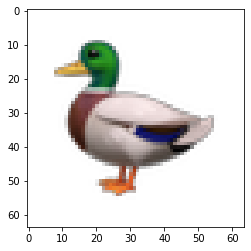

In [2]:
def load_image(url, max_size=48, padding=8):
    r = requests.get(url)
    img = Image.open(io.BytesIO(r.content))
    img.thumbnail((max_size, max_size), Image.ANTIALIAS)
    img = np.float32(img)/255.0
    img = np.pad(img,((8,8),(8,8),(0,0)))
    
    # premultiply RGB by Alpha
    img[..., :3] *= img[..., 3:]
    
    img = torch.Tensor(img).cuda()
    img = img.transpose(0,2)

    return img


def load_emoji(emoji):
    code = hex(ord(emoji))[2:].lower()
    url = 'https://raw.githubusercontent.com/iamcal/emoji-data/master/img-apple-64/%s.png' % code
    return load_image(url)


image = load_emoji("🦆")

plt.imshow(image.transpose(0,2).cpu())

In [7]:
class Automata(nn.Module):

    def __init__(self, grid_size, n_channels):

        super(Automata, self).__init__()

        self.n_channels = n_channels
        self.grid_size = grid_size

        self.filters = torch.Tensor([[[[-1, 0, 1],
                                       [-2, 0, 2],
                                       [-1, 0, 1]
                                       ]],
                                     [[[-1, -2, -1],
                                       [0, 0, 0],
                                       [1, 2, 1]
                                       ]],
                                     [[[0, 0, 0],
                                       [0, 1, 0],
                                       [0, 0, 0]
                                       ]]]).cuda()

        self.mapper = nn.Sequential(
            nn.Linear(3*n_channels, 128),
            nn.ReLU(),
            nn.Linear(128, n_channels),
            nn.Tanh()
        )

        self.mapper[2].weight.data.fill_(0)
        self.mapper[2].bias.data.fill_(0)

    def perception(self, x):

        conved = nn.functional.pad(x, (1, 1, 1, 1), mode="reflect")
        conved = nn.functional.conv2d(conved, model.filters)
        conved = conved.view(1, 3*self.n_channels, -1)

        conved = conved.transpose(1, 2)
        conved = self.mapper(conved)

        conved = conved.transpose(1, 2)
        conved = conved.view(self.n_channels, 1, *self.grid_size)

        can_update = torch.rand_like(conved) < 0.75
        
        return conved*can_update

    def forward(self, x, iterations):
        
        model.history = torch.zeros(iterations, *x.shape)
        
        for i in range(iterations):

            conved = self.perception(x)

            x = x + conved

            is_alive = nn.functional.max_pool2d(
                x[3], (3, 3), stride=1, padding=1) > 0

            x = x*is_alive
            x[:4].clamp_(0, 1)
            
            model.history[i] = x

        return x

In [30]:
n_epochs = 2500

lr = 0.0001

n_channels = 16

model = Automata((64, 64), n_channels).cuda()

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

losses = []

for i in range(n_epochs):
    
    iterations = random.randint(64,96)
    
    initial_state = torch.rand(n_channels, 1, 32, 32).cuda()
    initial_state = initial_state < 0.01
    initial_state = initial_state.float()
    initial_state = nn.functional.pad(initial_state,(16,16,16,16))

    out = model(initial_state,iterations)[:4].squeeze()

    optimizer.zero_grad()

    loss = criterion(out, image)

    loss.backward()
    optimizer.step()

    if i % 100 == 0:
    
        print(i, float(loss.cpu().detach()))
        
    losses.append(loss)

0 0.10192038118839264
100 0.04451324790716171
200 0.04124295711517334
300 0.03751397132873535
400 0.03242340683937073
500 0.03219525143504143
600 0.03593581169843674
700 0.030108803883194923
800 0.028365684673190117
900 0.02715015783905983
1000 0.03235644847154617
1100 0.0273980014026165
1200 0.028184516355395317
1300 0.028299249708652496
1400 0.027779381722211838
1500 0.022179700434207916
1600 0.023640193045139313
1700 0.021697960793972015
1800 0.022124124690890312
1900 0.027920421212911606
2000 0.019696181640028954
2100 0.018128085881471634
2200 0.02197548747062683
2300 0.01932079903781414
2400 0.024488437920808792


In [96]:
for i in range(n_epochs):
    
    iterations = random.randint(64,96)
    
    initial_state = torch.rand(n_channels, 1, 32, 32).cuda()
    initial_state = initial_state < 0.01
    initial_state = initial_state.float()
    initial_state = nn.functional.pad(initial_state,(16,16,16,16))

    out = model(initial_state,iterations)[:4].squeeze()

    optimizer.zero_grad()

    loss = criterion(out, image)

    loss.backward()
    optimizer.step()

    if i % 100 == 0:
    
        print(i, float(loss.cpu().detach()))
        
    losses.append(loss)

0 0.00832260400056839
100 0.008597295731306076
200 0.00906833540648222
300 0.008945656940340996
400 0.012275359593331814
500 0.017052747309207916
600 0.008193854242563248
700 0.012055961415171623
800 0.010173311457037926
900 0.00832013227045536
1000 0.013547383248806
1100 0.012117059901356697
1200 0.01055285707116127
1300 0.009862818755209446
1400 0.010821046307682991
1500 0.01233009435236454
1600 0.012188507243990898
1700 0.00919179804623127
1800 0.007147499360144138
1900 0.009406103752553463
2000 0.009521925821900368
2100 0.013775221072137356
2200 0.005574600771069527
2300 0.01044975034892559
2400 0.007980147376656532


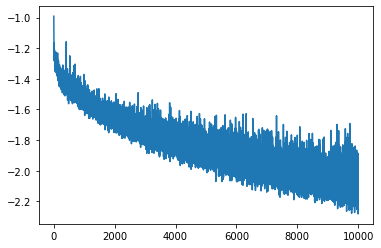

In [98]:
plt.plot(np.log10(losses))

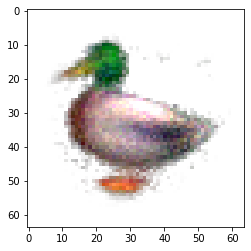

In [99]:
plt.imshow(model.history[-1][:4,0].transpose(0,2).cpu().detach())
